PCA over bert (then over all modalities)
See if features are seperable


Otherwise do same over features from model

In [112]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print(device)

cuda:0


In [3]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)',text) ]

In [98]:
LLM = "bert-base-uncased"

In [99]:
lv1_lv3 = dict({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:2, 17:2, 18:2})

In [100]:
class DATA():

    def __init__(self):
        self.dataset_llm = []
        self.dataset_opensmile = []
        self.dataset_cps_f = []
        self.dataset_cps_i = []
        self.dataset_action = []
        self.dataset_gamr = []

        self.targets = []

    def openLLM(self, filename):
        data = pd.read_csv(filename)
        for i in range(len(data)):
            self.dataset_llm.append(np.asarray(data.iloc[i]).tolist())
        global llm_size
        llm_size = len(self.dataset_llm[-1])
    
    
    def openSmile(self,filename):
        data = pd.read_csv(filename)
        for i in range (data.shape[0]):
            # print(f'C:\\Users\\Bbykitty\\OneDrive - Colostate\\Research\\Initial Observations for Fib Weights\\Data\\Segment Analysis\\{filename[filename.index("Group_"):filename.index("Group_")+8]}\\segments_oracle\\{filename[filename.index("Group_"):filename.index("Group_")+8]}_'+str(i)+'.wav')
            row=data[data['file']==f'C:\\Users\\bradf\\OneDrive - Colostate\\Research\\Initial Observations for Fib Weights\\Data\\Segment Analysis\\{filename[filename.index("Group_"):filename.index("Group_")+8]}\\segments_oracle\\{filename[filename.index("Group_"):filename.index("Group_")+8]}_'+str(i)+'.wav']
            tensor=np.nan_to_num(np.asarray(row.values[0][3:91],dtype=np.float32)).tolist()
            self.dataset_opensmile.append(tensor)


    def openCPS(self, filename):
        data = pd.read_csv(filename).fillna(0)
        for row in range(data.shape[0]):
            cps = data.iloc[row, 8:].fillna(0)
            self.dataset_cps_i.append(list(cps.values))
            cps_f = [0, 0, 0]
            for i, c in enumerate(list(cps.values)):
                if c == 1:
                    cps_f[lv1_lv3[i]] = 1
            self.dataset_cps_f.append(cps_f)

    def openAction(self, filename):
        data = pd.read_csv(filename, header=None).fillna(0)
        for row in range(data.shape[0]):
            self.dataset_action.append(data.iloc[row].to_list())



    def openGAMR(self, filename):
        data = pd.read_csv(filename, header=None).fillna(0)
        for row in range(data.shape[0]):
            self.dataset_gamr.append(data.iloc[row].to_list())
        

    def openTarget(self,filename):
        data = pd.read_csv(filename)
        for row in range(data.shape[0]):
            target = data.iloc[row, 3:].values.astype(int)
            self.targets.append(target.tolist())


    def get_datasets(self, rand=False):
        final_dataset=[]        
        for llm, opensmile, cps_f, cps_i, action, gamr, label in zip(self.dataset_llm, self.dataset_opensmile,self.dataset_cps_f, self.dataset_cps_i, self.dataset_action, self.dataset_gamr, self.targets):
            final_dataset.append([llm, opensmile, cps_f, cps_i, action, gamr, label])
            
        if rand:
            random.shuffle(final_dataset)
        return final_dataset

In [101]:
def read_data(dataset, root, file, llm="bert-base-uncased"):

    if llm in file:
        dataset.openLLM(root+"/"+file)
    if 'oracle_opensmile' in file:
        dataset.openSmile(root+"/"+file)
    elif 'CPS_Oracle' in file:
        dataset.openCPS(root+"/"+file)
    elif "Actions_Oracle_vectors" in file:
        dataset.openAction(root+"/"+file)
    elif "GAMR_Oracle_vectors" in file:
        dataset.openGAMR(root+"/"+file)
    elif 'CG.csv' in file:
        dataset.openTarget(root+"/"+file)
        

In [184]:
train_datasets = DATA()

In [185]:
for root, dirs,files in (os.walk(os. getcwd())):
    if "Group_" in root and "data" not in root:
        if "asr" not in root:
            print(root)
            for file in files:
                read_data(train_datasets, root, file, LLM)

/s/chopin/b/grad/benkh/Common Ground/Group_05


/s/chopin/b/grad/benkh/Common Ground/Group_07
/s/chopin/b/grad/benkh/Common Ground/Group_06
/s/chopin/b/grad/benkh/Common Ground/Group_02
/s/chopin/b/grad/benkh/Common Ground/Group_09
/s/chopin/b/grad/benkh/Common Ground/Group_03
/s/chopin/b/grad/benkh/Common Ground/Group_10
/s/chopin/b/grad/benkh/Common Ground/Group_08
/s/chopin/b/grad/benkh/Common Ground/Group_01
/s/chopin/b/grad/benkh/Common Ground/Group_04


In [104]:
len(train_datasets.dataset_llm) == len(train_datasets.dataset_opensmile) == len(train_datasets.dataset_cps_f) == len(train_datasets.dataset_cps_i) == len(train_datasets.dataset_action) == len(train_datasets.dataset_gamr) == len(train_datasets.targets)

True

In [106]:
np.sum(np.asarray(train_datasets.targets), axis=0)

array([52, 62, 88, 65,  4, 18])

In [108]:
len(train_datasets.get_datasets())

2873

In [124]:
class_2 = []
class_3 = []
class_other = []
for i in range(len(train_datasets.targets)):
    if train_datasets.targets[i] != [0, 0, 1, 0, 0, 0] and train_datasets.targets[i] != [0, 0, 0, 1, 0, 0]:
        class_other.append(i)
    elif train_datasets.targets[i] == [0, 0, 1, 0, 0, 0]:
        class_2.append(i)
    elif train_datasets.targets[i] == [0, 0, 0, 1, 0, 0]:
        class_3.append(i)

In [125]:
len(class_other) + len(class_2) + len(class_3)

2873

In [126]:
(np.array(train_datasets.dataset_llm)[class_2]).shape

(88, 768)

In [150]:
x_b = np.array(train_datasets.dataset_llm)

In [145]:
y_ = np.array(train_datasets.targets).argmax(axis=1)

In [291]:
pca = PCA(n_components=2)

In [292]:
pca.fit(x_b, y_)

PCA(n_components=2)

In [293]:
pca.components_.shape

(2, 768)

In [294]:
x_b_pca = pca.transform(x_b)

In [295]:
print(pca.explained_variance_ratio_)

[0.41498732 0.125392  ]


Text(0.5, 1.0, 'PCA (2 components) for bert features only : Statement vs Accept vs other')

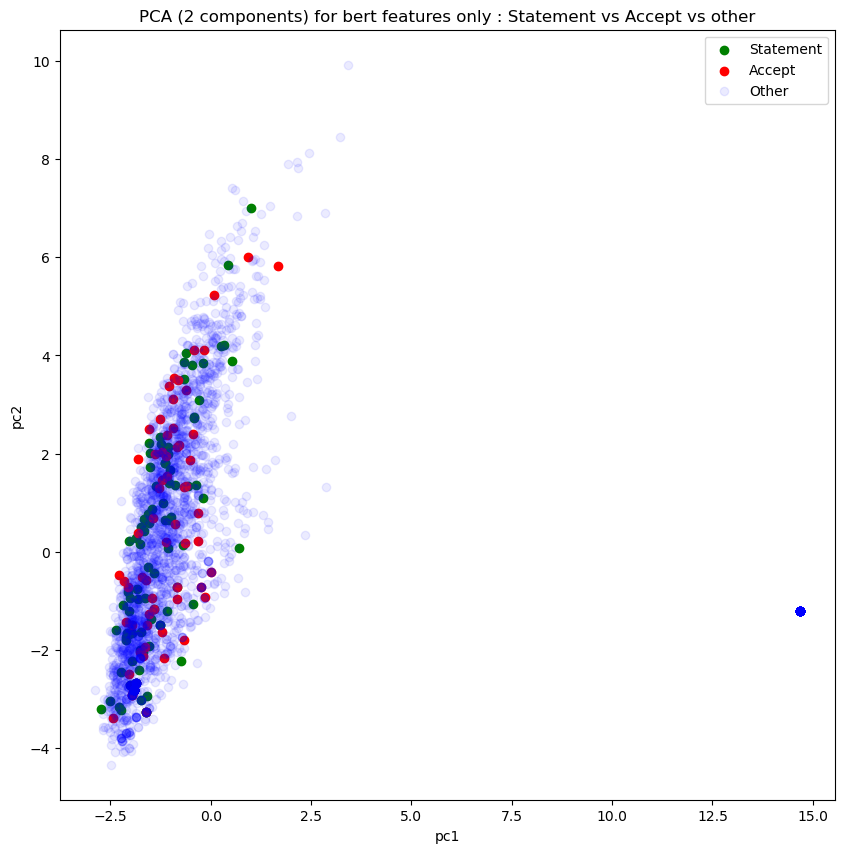

In [276]:
plt.figure(figsize=(10,10))
plt.scatter(x_b_pca[class_2][:,0],x_b_pca[class_2][:,1],color='green', alpha=1)
plt.scatter(x_b_pca[class_3][:,0],x_b_pca[class_3][:,1],color='red', alpha=1)
plt.scatter(x_b_pca[class_other][:,0],x_b_pca[class_other][:,1], color='blue', alpha=0.08)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(['Statement', 'Accept', 'Other'])
plt.title("PCA (2 components) for bert features only : Statement vs Accept vs other")

In [202]:
train_list = train_datasets.get_datasets()
train_list = [[a+b+c+d+e+f, g] for a,b,c,d,e,f,g in train_list]

In [210]:
all_x = []
for i in range(len(train_datasets.dataset_llm)):
    all_x.append(train_datasets.dataset_llm[i] + train_datasets.dataset_opensmile[i] + train_datasets.dataset_cps_f[i] + train_datasets.dataset_action[i] + train_datasets.dataset_gamr[i])

In [212]:
pca_all = PCA(n_components=2)

In [214]:
pca_all.fit(all_x, y_)

PCA(n_components=2)

In [217]:
all_x_pca = pca_all.transform(all_x)

In [284]:
print(pca_all.explained_variance_ratio_)

[0.96231485 0.01703301]


(-750.0, 750.0)

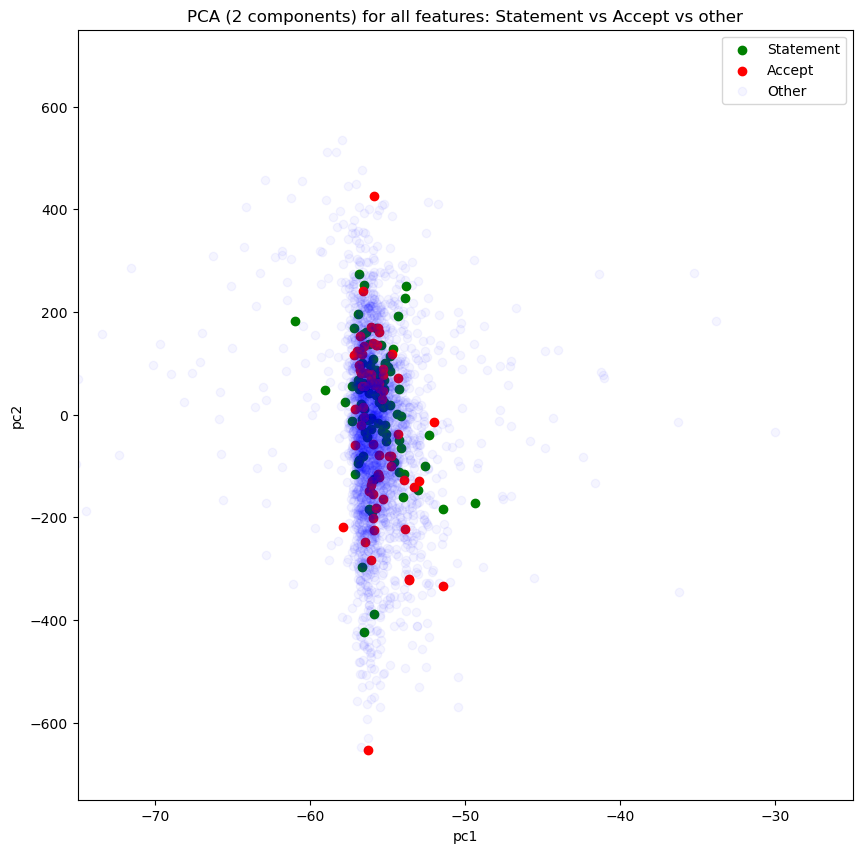

In [283]:
fig, ax = plt.subplots(figsize=(10, 10))
# plt.figure(figsize=(10,10))
ax.scatter(all_x_pca[class_2][:,0],all_x_pca[class_2][:,1],color='green', alpha=1)
ax.scatter(all_x_pca[class_3][:,0],all_x_pca[class_3][:,1],color='red', alpha=1)
ax.scatter(all_x_pca[class_other][:,0],all_x_pca[class_other][:,1], color='blue', alpha=0.04)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(['Statement', 'Accept', 'Other'])
plt.title("PCA (2 components) for all features: Statement vs Accept vs other")
ax.set_xlim(left=-75, right=-25)
ax.set_ylim(bottom = -750, top=750)